In [2]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from kneed import KneeLocator

from scipy.cluster import hierarchy

from autofeat.autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Clustering algorithms

In [4]:
df_norm = pd.read_csv('df/6_clear_normalised.csv')

In [233]:
# divide the data
X_norm = df_norm.drop(columns=['raw_value'], axis = 1)
Y = df_norm['raw_value']

In [180]:
# perform t-SNE
tsne = TSNE(n_components = 2, perplexity = 25, random_state=0)
X_tsne = tsne.fit_transform(X_norm)

What we know about our data is this:
* Have a high dimensionality
* Have outliers and noise
* Have overlapping clusters
* The data are presented in a numerical format

The most frequent and "classic" clustering method is considered k-means, which refers to **Centroid-based clustering**. However, it interacts poorly with outliers, but it does not require computational costs and is designed for numerical data. At least with its help we will be able to determine the approximate number of clusters.

**K-Means clustering**

Determine the number of clusters for the k-means method by calculating the sums of squared errors

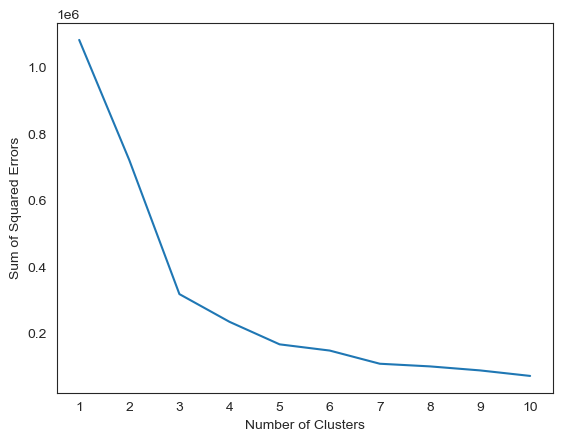

In [197]:
# k calculation method
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_tsne)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)

plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")

plt.show()

From the resulting graph, you must select the strongest inflection. We do this with the help of the kneed library

In [199]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

print('Optimal number of clusters:', kl.elbow)

Optimal number of clusters: 3


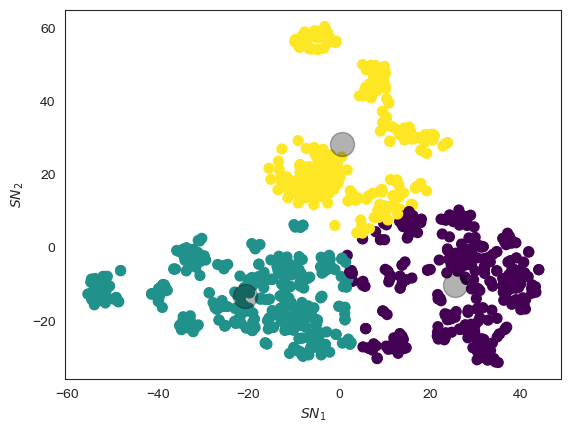

In [207]:
# the number of clusters to form as well as the number of centroids to generate
n_clusters = kl.elbow

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_tsne)

y_tsne = kmeans.predict(X_tsne)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.3);
plt.xlabel(r'$SN_1$')
plt.ylabel(r'$SN_2$')

plt.show()

Okay, but as we can see the "yellow" cluster is divided into two parts, so let's try another method for choosing the number of clusters - the hierarchical method. The advantage of this method is its high illustrative value.

**Hierarchical method**

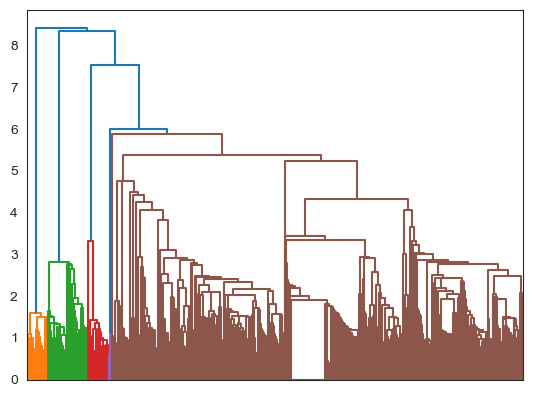

In [212]:
Z = hierarchy.linkage(X_tsne, 'single')
hierarchy.dendrogram(Z)

plt.xticks([])
plt.show()

Hierarchical method using the method of minimum distances between samples identified 4 main clusters.

So to split into 4 clusters, let's try one of the **Expectation-maximization Clustering** methods. The main "tool" that is used for this clusterization model is Gaussian Mixture Models (GMM). The advantage of this method is that the borders of each cluster compose ellipsoids of different measures. However, this method can only be used with a predetermined number of clusters.

**Gaussian Mixture Models**

Let's set the functions for the reconciliation of the GMM method

In [221]:
def draw_ellipse(position, covariances_, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # convert covariance to principal axes
    if covariances_.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariances_)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariances_)

    # draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    sns.set_style("white")
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

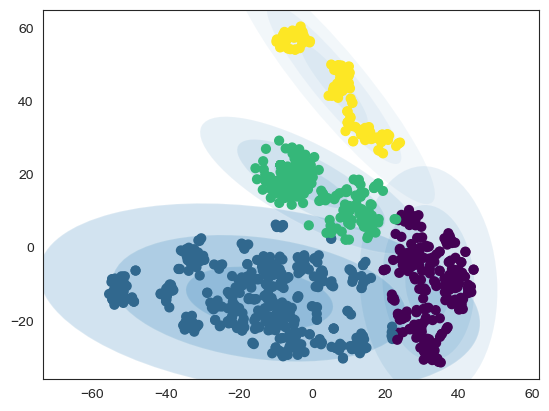

In [228]:
# perform GMM
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(X_tsne)

labels = gmm.predict(X_tsne)

# use the functions to draw the plots
plot_gmm(gmm, X_tsne)

This method produces the expected result, it splits the top cluster into two.

**Interpretation of clustering results**

Let's plot the dependencies of some parameters for connections from each cluster

In [295]:
df = pd.read_csv('df/6_clear.csv')

In [299]:
# set a new column depending on the obtained clusters
df['cluster'] = labels

<Axes: xlabel='cluster', ylabel='TSRW10'>

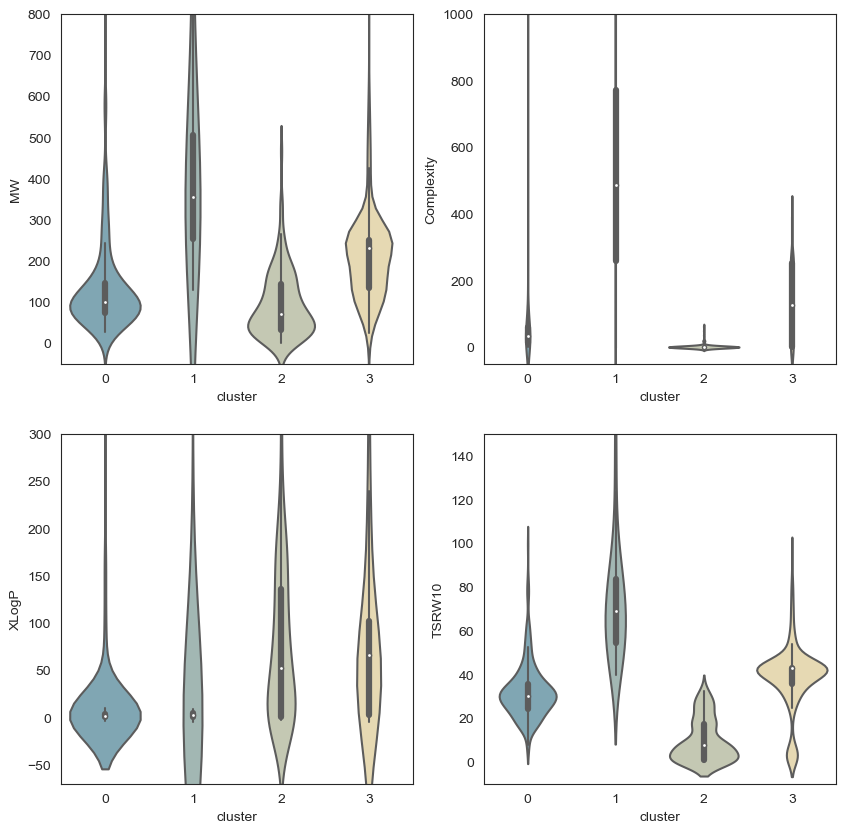

In [348]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# set limits
axes[0, 0].set_ylim(-50, 800)
axes[0, 1].set_ylim(-50, 1000)
axes[1, 0].set_ylim(-70, 300)
axes[1, 1].set_ylim(-10, 150)

# make plots
sns.violinplot(ax=axes[0, 0], 
            data=df, 
            x='cluster', 
            y='MW', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[0, 1], 
            data=df, 
            x='cluster', 
            y='Complexity', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[1, 0], 
            data=df, 
            x='cluster', 
            y='XLogP', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[1, 1], 
            data=df, 
            x='cluster', 
            y='TSRW10', 
            palette="blend:#7AB,#EDA")

As we can see the samples are separated by parameters between different clusters, which were obtained by the GMM method

### Feature engineering

Let's choose raw value as a predicted parameter, and 15 parameters with explicit chemical meaning as descriptors.

In [5]:
X_norm = df_norm[['MW', 'XLogP', 'TPSA', 'Complexity', 'Charge', 
                'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 
                'HeavyAtomCount', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 
                'NumAliphaticRings', 'NumAromaticRings']]
                
Y = df_norm['raw_value']

In [6]:
# divide the data
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.33, random_state=42)

AutoFeat is a python library that provides automated feature engineering using the AutoFeatRegressor model

In [ ]:
# let's set the model 
model = AutoFeatRegressor(apply_pi_theorem=True, categorical_cols=None,
          feateng_cols=None, feateng_steps=2, featsel_runs=3,
          transformations=('exp', 'log', 'abs', 'sqrt', '^2', '^3', '1/'),)
model

In [8]:
# transform the data to find new features
X_train_feature_creation = model.fit_transform(X_train, y_train)
X_test_feature_creation = model.transform(X_test)

In [9]:
# find out the number of new selected features
X_train_feature_creation.shape[1] - X_train.shape[1]

5

In [10]:
# let's see what features were obtained during the application of the method
list(X_test_feature_creation.columns)[-5:]

['XLogP/HeavyAtomCount',
 'sqrt(Complexity)*XLogP',
 'RotatableBondCount**2*log(MW)',
 'Charge**3*log(HeavyAtomCount)',
 'MW**2/HeavyAtomCount']

In our opinion, the most common sense feature is **XLogP/HeavyAtomCount**. By dividing the octanol/water distribution ratio by the number of heavy atoms, the contribution of a single functional group to this ratio can be estimated.

Also taking the logarithm of the molecular weight in the new descriptor **RotatableBondCount**2*log(MW)** seems reasonable. Such an action is justified because of the wide distribution of MW in our dataset.

### Feature selection

#### Techniques that are used to select descriptors

Wrapper methods use ML models to select features. The optimal set of features (not generalized to all models) is generated for a particular ML model. The MLxtend library can be used to solve problems.

1) Direct algorithms based on the gradual addition of new features to the model (step forward selection, sequential forward selection, sequential forward floating selection);
2) Inverse algorithms based on gradual removal of features from the model (step backward selection, sequential backward selection, sequential backward floating selection);
3) Algorithms that check all possible combinations of features (exhaustive feature selection).

Embedding methods select features based on the evaluation of the importance of the features in the model construction process. Compared to wraparound methods, they are less costly in terms of computational resources. The following models allow evaluating the importance of the features:

1) The use of linear models (linear regression in regression problems and logistic regression in L1-regulation-based classification problems);
2) Using decision tree models (DecisionTreeClassifier, RandomForestClassifier and GradientBoostingClassifier, importance of features is determined using feature_importances_).

In [6]:
df = pd.read_csv('6_clear_normalised.csv')

In [7]:
# create object MinMaxScaler
scaler = MinMaxScaler()

# normalize the data in the column "raw_value"
df['raw_value'] = scaler.fit_transform(df[['raw_value']])

In [8]:
df

,raw_value,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,HBondAcceptorCount,RotatableBondCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.057909,0.596174,0.596174,0.057909,0.791210,...,0.000000,0.010363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000
1,0.000000,0.037776,0.052365,0.111111,0.000000,0.039025,0.633952,0.633952,0.039025,0.793176,...,0.035211,0.025907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004733
2,0.000092,0.004489,0.007115,0.000000,0.000000,0.005751,0.408248,0.408248,0.005751,0.623449,...,0.000000,0.015544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.150970
3,0.000867,0.075389,0.095346,0.055556,0.130435,0.078133,0.706396,0.706396,0.078133,0.819636,...,0.042254,0.046632,0.000000,0.036364,0.036364,0.000000,0.000000,0.000000,0.000000,0.004733
4,0.001333,0.004489,0.007115,0.000000,0.000000,0.005751,0.408248,0.408248,0.005751,0.623449,...,0.000000,0.009326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053333,0.000947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,1.000000,0.040148,0.055011,0.000000,0.043478,0.045641,0.673887,0.673887,0.045641,0.873079,...,0.035211,0.088083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000
1067,1.000000,0.109165,0.137630,0.000000,0.000000,0.116156,0.717959,0.717959,0.116156,0.839412,...,0.147887,0.051813,0.000000,0.363636,0.000000,1.000000,0.000000,0.000000,0.000000,0.004733
1068,1.000000,0.007776,0.012323,0.000000,0.000000,0.007044,0.500000,0.500000,0.007044,0.572674,...,0.021127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004733
1069,1.000000,0.035705,0.047002,0.027135,0.019270,0.038989,0.566122,0.562285,0.038989,0.719904,...,0.024687,0.034002,0.005186,0.020065,0.015469,0.009911,0.007424,0.008414,0.040312,0.013123


In [9]:
# obtain features and target value
X = df.drop(['raw_value'], axis = 1) 
y = df[['raw_value']]

### Wrapper method (Forward Feature Selection)

In [ ]:
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, forward=True, k_features=5)
sfs.fit(X.values, y.values)

In [11]:
selected_cols = df.columns[list(sfs.k_feature_idx_)]
print(selected_cols)
print(sfs.k_feature_idx_)

Index(['NaaCH', 'ETA_beta_ns', 'ETA_eta_RL', 'MIC4', 'SRW09'], dtype='object')
(561, 649, 658, 716, 907)


In [12]:
# Obtain the indices of the feature importances
selected_feat_idx = sfs.k_feature_idx_
# Obtain feature names
selected_feat_names = df.columns[list(sfs.k_feature_idx_)]
X_selected = pd.DataFrame(X.values[:, selected_feat_idx], columns=selected_feat_names)
rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_selected, y.to_numpy().ravel())
feature_importances = rf.feature_importances_
print(feature_importances)

[0.08822043 0.16258969 0.15728053 0.39316968 0.19873967]


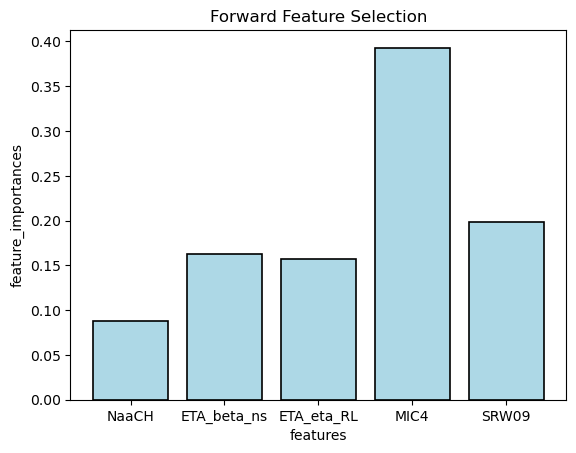

In [13]:
# create a bar chart
plt.bar(list(selected_feat_names), feature_importances, color='lightblue', edgecolor='black', linewidth=1.2)

# add the name of the graph and axis labels
plt.title("Forward Feature Selection")
plt.xlabel("features")
plt.ylabel("feature_importances")

# displaying the graph
plt.show()

### Embedding methods 
### (DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, Genetic Algorithm)

In [ ]:
dtr1 = DecisionTreeRegressor()
rfr1 = RandomForestRegressor()
gbr1 = GradientBoostingRegressor()
dtr1.fit(X.values, y.to_numpy().ravel())
rfr1.fit(X.values, y.to_numpy().ravel())
gbr1.fit(X.values, y.to_numpy().ravel())

In [16]:
dtr1_importances = dtr1.feature_importances_
rfr1_importances = rfr1.feature_importances_
gbr1_importances = gbr1.feature_importances_

methods_importances = [dtr1_importances, rfr1_importances, gbr1_importances]
names_methods = ['DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor']

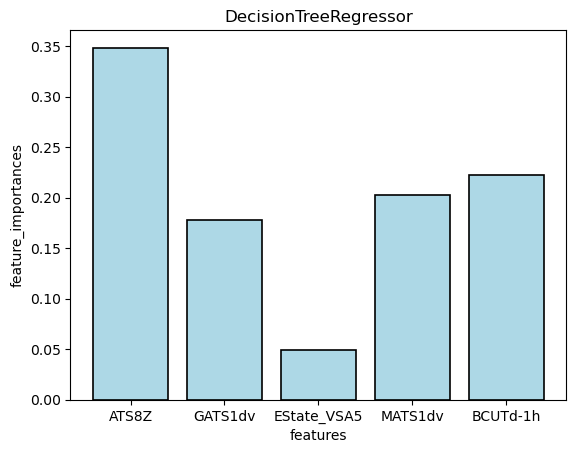

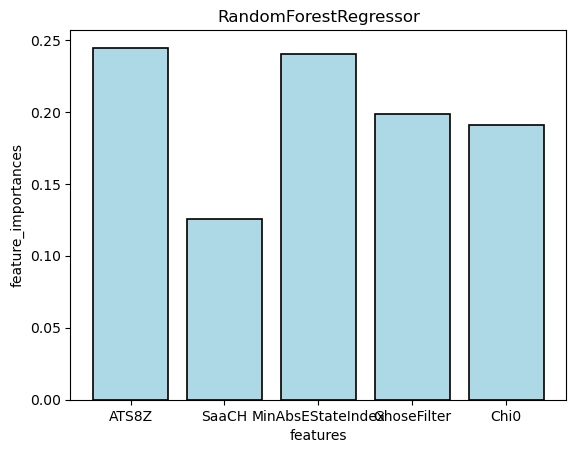

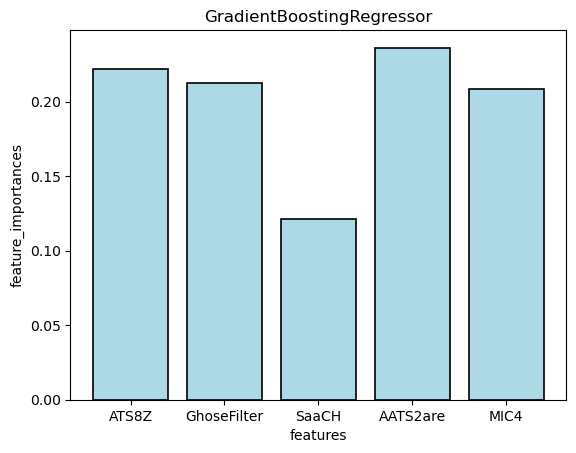

In [17]:
def embedding_method(method, name):
    # obtain the indices of the feature importances
    selected_feat_idx = np.argsort(method)[::-1]
    selected_feat_idx = selected_feat_idx[:5]
    # obtain feature names
    selected_feat_names = df.columns[list(selected_feat_idx)]
    X_selected = pd.DataFrame(X.values[:, selected_feat_idx], columns=selected_feat_names)
    rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    rf.fit(X_selected, y.to_numpy().ravel())
    feature_importances = rf.feature_importances_
    
    # create a bar chart
    plt.bar(list(selected_feat_names), feature_importances, color='lightblue', edgecolor='black', linewidth=1.2)
    # add the name of the graph and axis labels
    plt.title(f"{name}")
    plt.xlabel("features")
    plt.ylabel("feature_importances")
    # displaying the graph
    plt.show()
    
for i in range(len(methods_importances)):
    embedding_method(methods_importances[i], names_methods[i])

In [18]:
from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()

model = GeneticSelectionCV(
    estimator, cv=5, verbose=0,
    scoring="r2", max_features=5,
    n_population=500, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=20,
    caching=True, n_jobs=-1)

model = model.fit(X, y.to_numpy().ravel())

In [19]:
print('Features:', X.columns[model.support_])

Features: Index(['nHetero', 'StsC', 'AETA_eta_L', 'BIC3', 'Chi0n'], dtype='object')


In [20]:
# obtain the indices of the feature importances
selected_feat_idx = np.where(model.support_)[0]
# obtain feature names
selected_feat_names = list(X.columns[model.support_].tolist())
X_selected = pd.DataFrame(X.values[:, selected_feat_idx], columns=selected_feat_names)
rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_selected, y.to_numpy().ravel())
feature_importances = rf.feature_importances_
print(feature_importances)

[0.13227769 0.06433005 0.23653381 0.24311642 0.32374203]


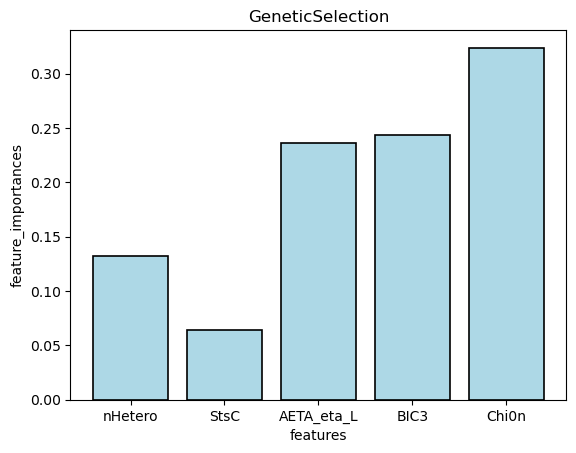

In [21]:
# create a bar chart
plt.bar(list(selected_feat_names), feature_importances, color='lightblue', edgecolor='black', linewidth=1.2)

# add the name of the graph and axis labels
plt.title("GeneticSelection")
plt.xlabel("features")
plt.ylabel("feature_importances")

# displaying the graph
plt.show()